# Calculation of electric demand of the heat pump

In this notebook, the electric demand of the heat pump is calculated.
> - The buildings demand of cooling power (kW thermal) is defined in the given data set from CityLearn Challenge.
> - The coefficient of performance (COP) is calculated based on a simplified equation. 
> - Suitable and realistic parameters are determined. 

In [1]:
import pandas as pd
import json
#from utils import span
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Preprocess data

In [2]:
# load csv
b = pd.read_csv('../data/preprocessed/Building_5.csv').astype({'datetime': 'datetime64'}) # keep index
# convert datetime column to pd datetime format
b.datetime = pd.to_datetime(b.datetime)
# Extract additional features from timestamp column
b = b.assign(
    timestamp = b['datetime'], # timestamp column is useful for seaborn lineplots
    #date = lambda x: x['timestamp'].dt.date,
    year = lambda x: x['timestamp'].dt.year,
    month = lambda x: x['timestamp'].dt.month,
    day = lambda x: x['timestamp'].dt.day,
    dayofweek = lambda x: x['timestamp'].dt.dayofweek,
    dayofyear = lambda x: x['timestamp'].dt.dayofyear,
    hour = lambda x: x['timestamp'].dt.hour,
)
b.set_index('datetime',inplace=True) # set the datetime column as index column
b.head()

,daylight_savings,indoor_temp,avg_unmet_cooling_temp,indoor_hum,equipment_electric_power_kW,dhw_heating_kW,cooling_load_kW,solar_generation_W_kW,outdoor_temp,outdoor_hum,...,solar_generation_kW,electric_load_hp_kW,net_load_kW,timestamp,year,month,day,dayofweek,dayofyear,hour
datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-02 00:00:00,0,22.02,0.0,55.86,11.7,3.00,1.61,0.0,9.40,94.12,...,0.0,0.170,14.870,2008-01-02 00:00:00,2008,1,2,2,2,0
2008-01-02 01:00:00,0,21.78,0.0,52.90,7.2,3.36,0.47,0.0,7.61,93.00,...,0.0,0.029,10.589,2008-01-02 01:00:00,2008,1,2,2,2,1
2008-01-02 02:00:00,0,21.77,0.0,50.06,8.1,0.36,0.58,0.0,8.11,93.00,...,0.0,0.043,8.503,2008-01-02 02:00:00,2008,1,2,2,2,2
2008-01-02 03:00:00,0,21.81,0.0,47.95,12.4,0.12,1.19,0.0,8.36,93.00,...,0.0,0.096,12.616,2008-01-02 03:00:00,2008,1,2,2,2,3
2008-01-02 04:00:00,0,21.77,0.0,46.91,8.6,0.00,0.59,0.0,8.78,93.00,...,0.0,0.053,8.653,2008-01-02 04:00:00,2008,1,2,2,2,4


In [3]:
# create data snipped in a certain time range
b_snip = b.loc[pd.date_range('2011-01-10 00:00', '2011-01-12 23:00', freq='H')]

### Getting an overview on the power demand of 1 building in a certain time frame

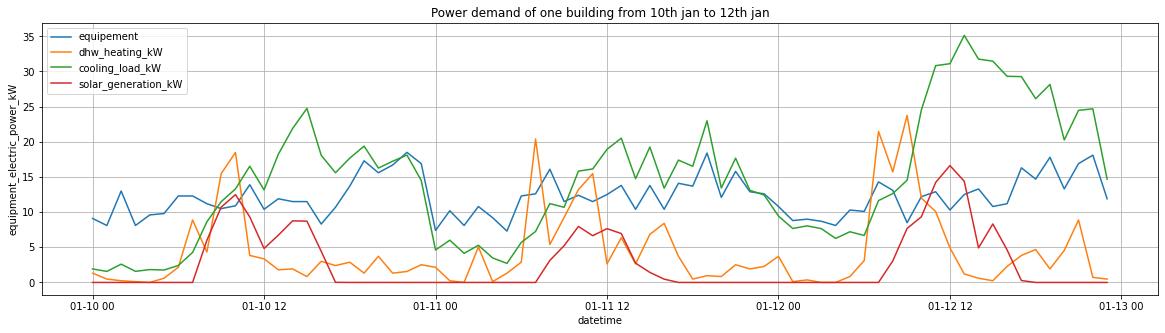

In [16]:
# get an overview by plotting the data
plt.figure(figsize=(20,5))
sns.lineplot(data=b_snip,x='datetime',y='equipment_electric_power_kW',label='equipement')
sns.lineplot(data=b_snip,x='datetime',y='dhw_heating_kW',label='dhw_heating_kW')
sns.lineplot(data=b_snip,x='datetime',y='cooling_load_kW',label='cooling_load_kW')
sns.lineplot(data=b_snip,x='datetime',y='solar_generation_kW',label='solar_generation_kW')
plt.title('Power demand of one building from 10th jan to 12th jan')
plt.grid('major')
plt.legend()

## Calculation of electric power consumption of the heat pump and the electric heater for DHW

### Heat pump coefficient of performance (COP)

In [5]:
# calculate heat pump power consumption
# parameter set up
eta_hpc = 0.15; # technical efficiency coefficient 0.2 ... 0.3 typically
temp_target_c = 5; # target temperature for hp cooling, typically 7 ... 10 °C, this equals approx. the temperature of the chilled water storage
T_th = 273.15; # thermodynamic temperature in Kelvin [K] corresponding to 0 °C 
# adding a COP column to the data frame
b_snip['COP_c'] = eta_hpc * (temp_target_c + T_th)/ ((b_snip['outdoor_temp'] + T_th) - (temp_target_c + T_th)) 

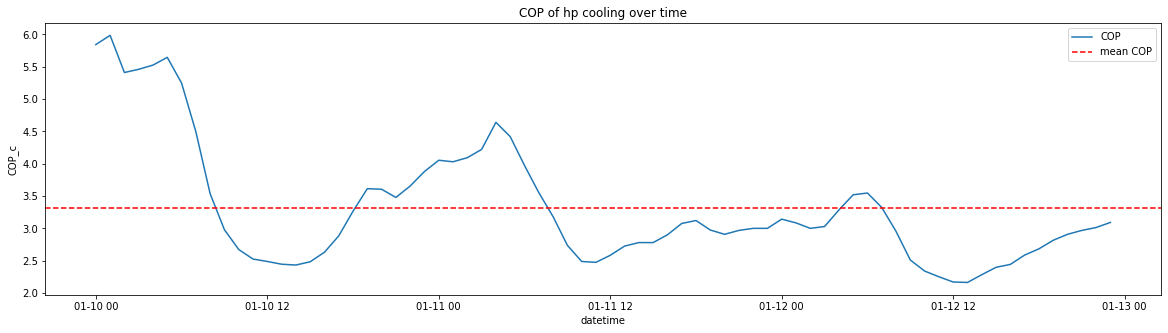

In [24]:
# COP plot of hp cooling incl. mean COP value (horizontal line)
plt.figure(figsize=(20,5))
sns.lineplot(data=b_snip,x='datetime',y='COP_c',label='COP')
#sns.lineplot(data=b4_snip,x='datetime',y='outdoor_temp')
plt.axhline(b_snip['COP_c'].mean(),color='red',linestyle='--',label='mean COP')
plt.legend()
#plt.axhline(0)
#plt.ylim(-10,25)
plt.title('COP of hp cooling over time');

- theoretical max COP for cooling is approx. 7.8, typical values are 2 ... 4; so the values seem realistic, but tend to be a little bit high
- this hp seems to perform well, the technical efficiency coeff. is already reduced to 0.15 to not have an unrealistic well performing device


### Details on COP

- how is the COP changing over outdoor temperature?
- what is the limit of the approximated equation for COP calculation?

The constant target temperature for cooling is:  5

Min outdoor temp and max values of realistic cop: 
           temp       cop
104  10.429799  7.683985


Text(0.5, 1.0, 'COP cooling over outdoor temperature')

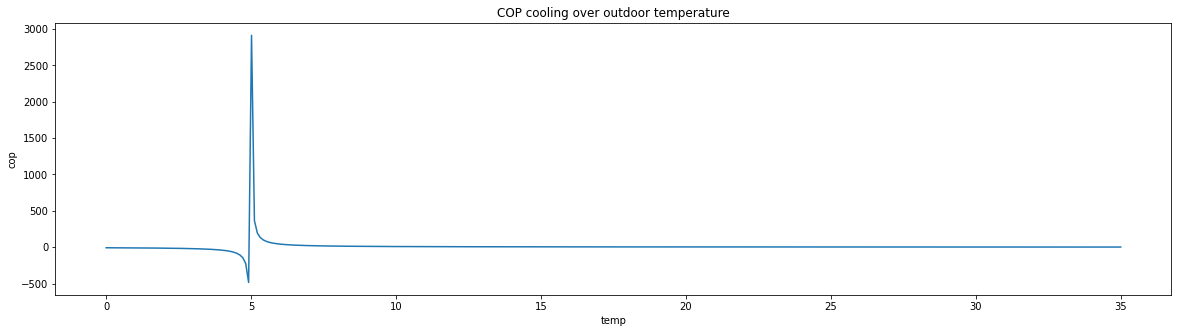

In [7]:
# cop over outdoortemp
# create temperature list
from numpy import linspace

temp = list(linspace(0,35,350)) # create list of temperature between 0 and 35 °C
df_cop = pd.DataFrame(temp,columns=['temp']) # create dataframe from temperature list
df_cop['cop'] = eta_hpc * (temp_target_c + T_th)/ ((df_cop['temp'] + T_th) - (temp_target_c + T_th)) # add a COP column
print('The constant target temperature for cooling is: ',temp_target_c)
print('\nMin outdoor temp and max values of realistic cop: \n', df_cop.loc[(df_cop['cop']<7.8)&(df_cop['cop']>0)].head(1)) # realistic is a cop between 0 and 7.8
plt.figure(figsize=(20,5))
sns.lineplot(data=df_cop,x='temp',y='cop')
plt.title('COP cooling over outdoor temperature')


- if the difference between outdoor temp and target temp for cooling gets lower than 5 K, the calculated COP increases to unrealistic values, thus minimum difference between outdoor and target temperature should be delta_Tc_min = approx. 5
- in summer, the proposed target temp of 7 ... 10 °C works fine, in winter a lower target has to be chosen (approx. 3 ... 5 °C). The following graph - COP over outdoor_temp - shows how the cop changes depending on outdoor temperature with a constant target temperature). Only values for temp > (target_temp + delta_Tc_min) are realistic!
- in general: the lower the target temp (temperature of the chilled water storage), the higher the electric energy consumption of the hp.
- for a first approach a suggest a constant target temperature for cooling set to target_Tc = 5.

### Electric power usage by hp and heater

In [9]:
# Calculate the electric energy consumption of the hp for cooling
b_snip['electric_load_hp_kW'] = b_snip['cooling_load_kW'] / b_snip['COP_c'] # add a column with the electric consumption [kW]
# Calculate the electric energy consumption of the heater for DHW heating
eta_heater = 0.99 # efficiency of the electric heater for DHW, usually close to 1
b_snip['electric_load_heater_kW'] = b_snip['dhw_heating_kW']/eta_heater # add a column with the electric consumption of heater [kW]

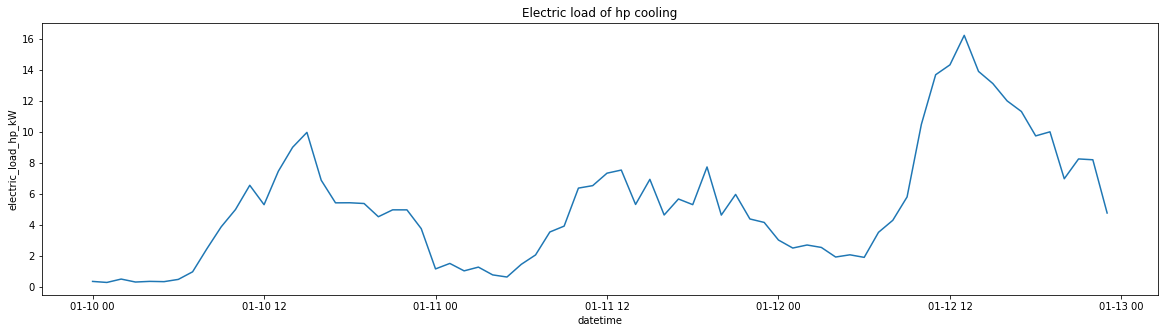

In [10]:
# electric power consumption of hp for cooling
plt.figure(figsize=(20,5))
sns.lineplot(data=b_snip,x='datetime',y='electric_load_hp_kW')
plt.title('Electric load of hp cooling');

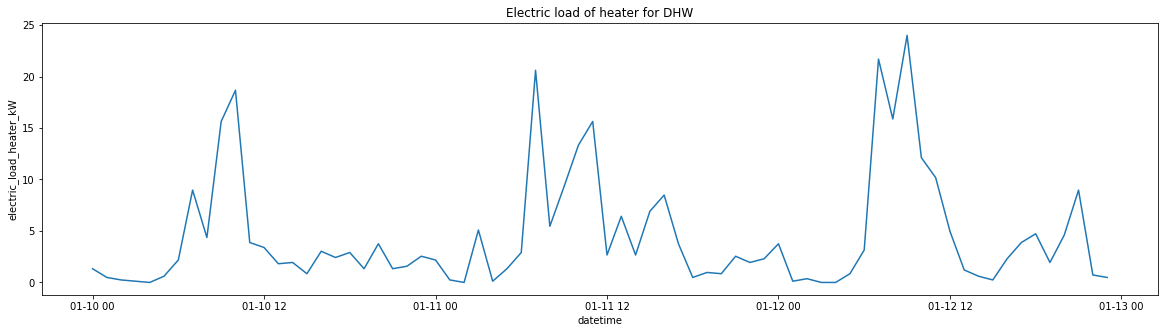

In [11]:
# electric power consumption of heater for DHW
plt.figure(figsize=(20,5))
sns.lineplot(data=b_snip,x='datetime',y='electric_load_heater_kW')
plt.title('Electric load of heater for DHW');


### Final plot with all electric powers
- with outdoor_temp as a reference
- with cooling_load_hp_kW as a reference

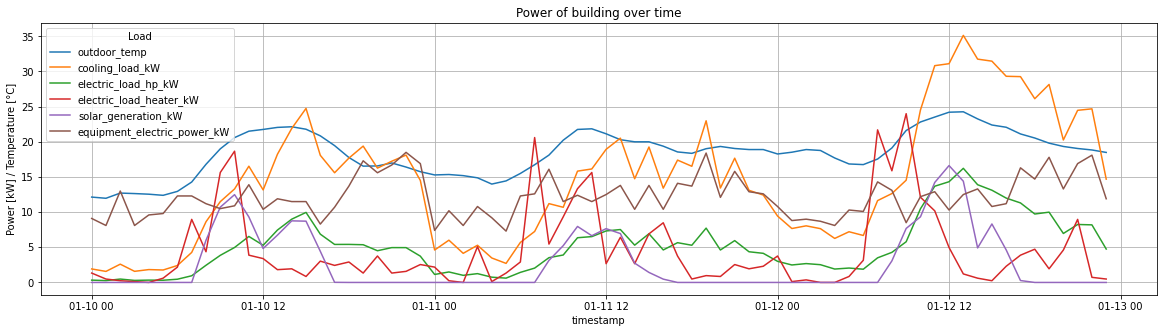

In [25]:
# plotting power plots
# choose columns to plot
df_plot = b_snip.loc[:,('timestamp','outdoor_temp','cooling_load_kW','electric_load_hp_kW','electric_load_heater_kW','solar_generation_kW','equipment_electric_power_kW')]

# melt dataframe for plotting
df_plot = pd.melt(df_plot, 'timestamp', var_name='Load', value_name='Value') 
plt.figure(figsize=(20,5))
sns.lineplot(data=df_plot,x='timestamp',y='Value',hue='Load')
plt.title('Power of building over time')
plt.ylabel('Power [kW] / Temperature [°C]')
plt.grid('major')

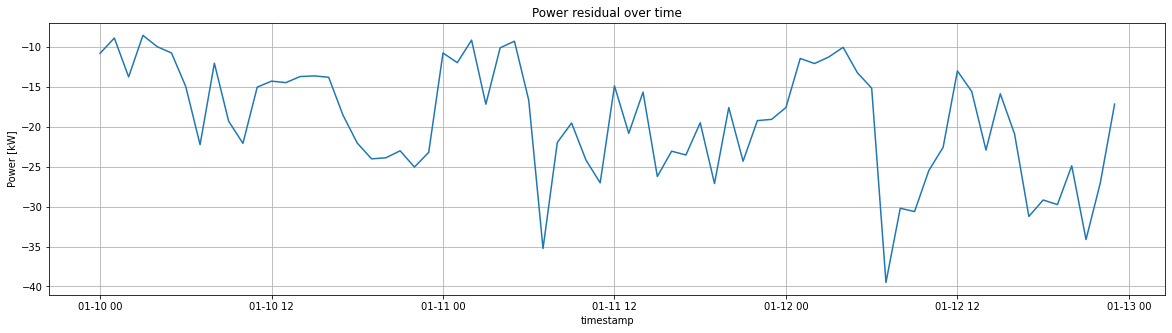

In [13]:
# Power residual
b_snip['power_residual'] = b_snip['solar_generation_kW'] \
                                - b_snip['electric_load_hp_kW'] \
                                - b_snip['electric_load_heater_kW'] \
                                - b_snip['equipment_electric_power_kW']
plt.figure(figsize=(20,5))
sns.lineplot(data=b_snip,x='timestamp',y='power_residual')
plt.title('Power residual over time')
plt.ylabel('Power [kW]')
plt.grid('major')
